# Нейронные сети 

Сегодня поговорим про рекурентные, генеративные нейросети, дообучение нейросетей и прогнозирование временных рядов при помощи нейросетей

## RNN

Когда мы рассматриваем последовательности данных (временные ряды, слова в предложении, кадры в видео), нам хочется как-то учитывать связи между соседними объектами. Для этого нужно реализовать что-то, похожее на память. Для этого существует ячейка рекурентной нейросети.

![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/29b/c91/5f5/29bc915f5ac31f4fab7931a01d773655.png)

RNN в теории хорошо улавливает как информацию, расположенную неподалеку, так и далеко.

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-shorttermdepdencies.png)

Но это только в теории. На практике мы сталкиваемся с проблемой затухания градиента и модель просто не может обучиться, когда итерацией слишком много.

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-longtermdependencies.png)

Тогда на помощь приходят другие похожие архитектуры - LSTM и GRU. Эти ячейки умеют выбирать какую информацию имеет смысл пропускать дальше, а какую нужно "забыть".

![](https://habrastorage.org/r/w1560/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png)

Все эти нейросети довольно долго обучаются, потому что обучаются только последовательно, в то время как многие другие нейросети умеют обучаться параллельно на нескольких батчах.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [59]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Описание датасета

Датасет на английском языке с отзывами критиков с IMDb. Есть позитивные и негативные отзывы. Нужно научиться классифицировать отзыв.

Пример:
- Liked Stanley & Iris very much. Acting was very good. Story had a unique and interesting arrangement…	 (Positive)
- This is the worst thing the TMNT franchise has ever spawned. I was a kid when this came out and I still thought it was deuce…	(Negative)

In [44]:
! wget https://victorzhou.com/movie-reviews-dataset.zip

--2021-11-20 15:26:56--  https://victorzhou.com/movie-reviews-dataset.zip
Resolving victorzhou.com (victorzhou.com)... 172.67.153.220, 104.21.72.186, 2606:4700:3035::6815:48ba, ...
Connecting to victorzhou.com (victorzhou.com)|172.67.153.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62951389 (60M) [application/zip]
Saving to: ‘movie-reviews-dataset.zip’

movie-reviews-datas 100%[===================>]  60.03M  53.5MB/s    in 1.1s    

2021-11-20 15:26:58 (53.5 MB/s) - ‘movie-reviews-dataset.zip’ saved [62951389/62951389]



In [ ]:
! unzip movie-reviews-dataset.zip

In [48]:
!ls movie-reviews-dataset/test

neg  pos


## Напишем функции для предобработки

## Задача

Дописать функцию preprocess_str. Добавить лемматизацию, убрать пунктуацию, привести к нижнему регистру.

In [83]:
def preprocess_str(text):
    # Ваш код здесь
    return text


In [60]:
# Пример лемматизации для английского языка
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()
 
print("rocks :", lemmatizer.lemmatize("rocks"))

rocks : rock


In [61]:
# Пример удаления пунктуации
import re
s = "string. With. Punctuation?"
s = re.sub(r'[^\w\s]','',s)
s

'string With Punctuation'

## Загрузим данные

In [164]:
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace


def prepare_data(dir):
  data = text_dataset_from_directory(dir)
  texts = []
  labels = []
  for text, label in data:
      texts.extend(text.numpy().tolist())
      labels.extend(label.numpy().tolist())
  return pd.DataFrame({'text': texts, 'label': labels})

train_data = prepare_data("/content/movie-reviews-dataset/train")
test_data = prepare_data("/content/movie-reviews-dataset/test")

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [165]:
def final_preprocess(text):
    text = str(text)
    return preprocess_str(text.replace('<br />', ' '))

train_data['preprocessed'] = train_data.text.apply(final_preprocess)
test_data['preprocessed'] = test_data.text.apply(final_preprocess)

In [166]:
train_data['preprocessed'].iloc[:10].values

array(['b"this movie was awful in the worst way: you just didn\'t care. you didn\'t care what happened in the plot; you didn\'t care about the characters. everyone was devoid of heart. i ended up walking out about an 45 minutes into it because i simply didn\'t want to subject my mind to it any more. there is far too much sex in the film. sex can be okay; it can even make the movie (hence karma sutra) but the intercourse here was not beautiful or sexy. it was just ugly. don\'t see this film."',
       "b'i read many commits when it was in the theaters and they were all bad....i think you have to be a certain type of person to enjoy these movies. if you are not a person that enjoyed the waltons or little house...u will not understand nor enjoy these movies...  now about loves abiding joy...i knew he was bad news from the start of the movie....i wish it would have shown more of the end instead of letting you just think it. this movie has a lot to do with jeff....it is 6 years later so you

Классы сбалансированны, можем использовать accuracy

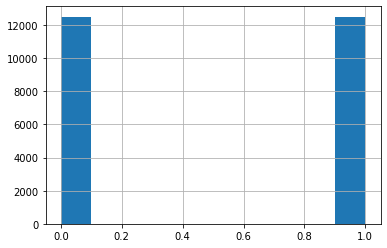

In [167]:
train_data['label'].hist()

## Построим модель

In [168]:
# Создадим слой, который будет обрабатывать входные данные 
max_tokens = 1000
max_len = 100
vectorize_layer = TextVectorization(
  max_tokens=max_tokens,
  output_mode="int",
  output_sequence_length=max_len,
)
vectorize_layer.adapt(train_data.preprocessed)

In [181]:
model = Sequential()
model.add(Input(shape=(1,), dtype="string"))

model.add(vectorize_layer)

# Добавляем единицу для всех слов, которые "out of vocabulary"
model.add(Embedding(max_tokens + 1, 128))

model.add(LSTM(64))

model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

In [98]:
batch_size = 128
model.fit(train_data.preprocessed, train_data.label, batch_size=batch_size, epochs=10)

Epoch 1/10
196/196 [==============================] - 40s 206ms/step - loss: 0.4464 - accuracy: 0.7970
Epoch 2/10
196/196 [==============================] - 40s 206ms/step - loss: 0.4266 - accuracy: 0.8062
Epoch 3/10
196/196 [==============================] - 40s 206ms/step - loss: 0.4133 - accuracy: 0.8120
Epoch 4/10
196/196 [==============================] - 40s 204ms/step - loss: 0.3938 - accuracy: 0.8176
Epoch 5/10
196/196 [==============================] - 40s 206ms/step - loss: 0.3821 - accuracy: 0.8271
Epoch 6/10
196/196 [==============================] - 40s 205ms/step - loss: 0.3710 - accuracy: 0.8282
Epoch 7/10
196/196 [==============================] - 40s 205ms/step - loss: 0.3586 - accuracy: 0.8370
Epoch 8/10
196/196 [==============================] - 40s 203ms/step - loss: 0.3445 - accuracy: 0.8468
Epoch 9/10
196/196 [==============================] - 40s 205ms/step - loss: 0.3290 - accuracy: 0.8561
Epoch 10/10
196/196 [==============================] - 44s 223ms/step - l

## Задача 

- Добавить второй слой LSTM (сразу вслед за первым). В первый слой нужно добавить параметр `return_sequences=True`
- Добавить Dropout в один из LSTM слоев. Пример: `LSTM(64, dropout=0.25)`
- Добавить Dropout после Dense слоя

Обучить модель на 10 эпохах. Оценить качество модели на тестовой выборке.

In [ ]:
# Оцените качество здесь


## Задача

Обучить пайплайн с TF-IDF и логистической регрессией на треин выборке и оценить качество на тестовой.

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

## Генеративные сети

https://www.tensorflow.org/tutorials/generative/dcgan

## Файн-тюнинг моделей

https://www.tensorflow.org/tutorials/images/transfer_learning

## Прогнозирование временных рядов при помощи LSTM

https://www.tensorflow.org/tutorials/structured_data/time_series



## Домашняя работа

Ознакомиться с материалами ниже и доделать домашку с предыдущих заданий

[Статья с сентимент-анализом ревью с IMDb](https://victorzhou.com/blog/keras-rnn-tutorial/)

[Видео про трансформеры и seq2seq модели](https://www.youtube.com/watch?v=TQQlZhbC5ps)

[Файн-тюнинг модели ResNet на датасете камуфлированной одежды](https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/)

[Очень подробно про LSTM для заинтересованных](https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/LSTM_Understanding_Output_Types.ipynb)